# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the time series of the challenge

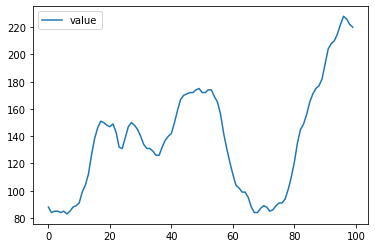

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('data/wwwusage.csv', names=['value'], header=0)
y = df.value
df.plot();

In [61]:
y

0      88.0
1      84.0
2      85.0
3      85.0
4      84.0
      ...  
95    222.0
96    228.0
97    226.0
98    222.0
99    220.0
Name: value, Length: 100, dtype: float32

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [3]:
from statsmodels.tsa.stattools import adfuller
adfuller(df.value)[1]

0.12441935447109442

The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

In [25]:
print('p-value: ', adfuller(y.diff(1).fillna(0))[1])

p-value:  0.07202830223065532


In [27]:
print('p-value: ', adfuller(y.diff(1).diff(1).fillna(0))[1])

p-value:  1.996247484971377e-17


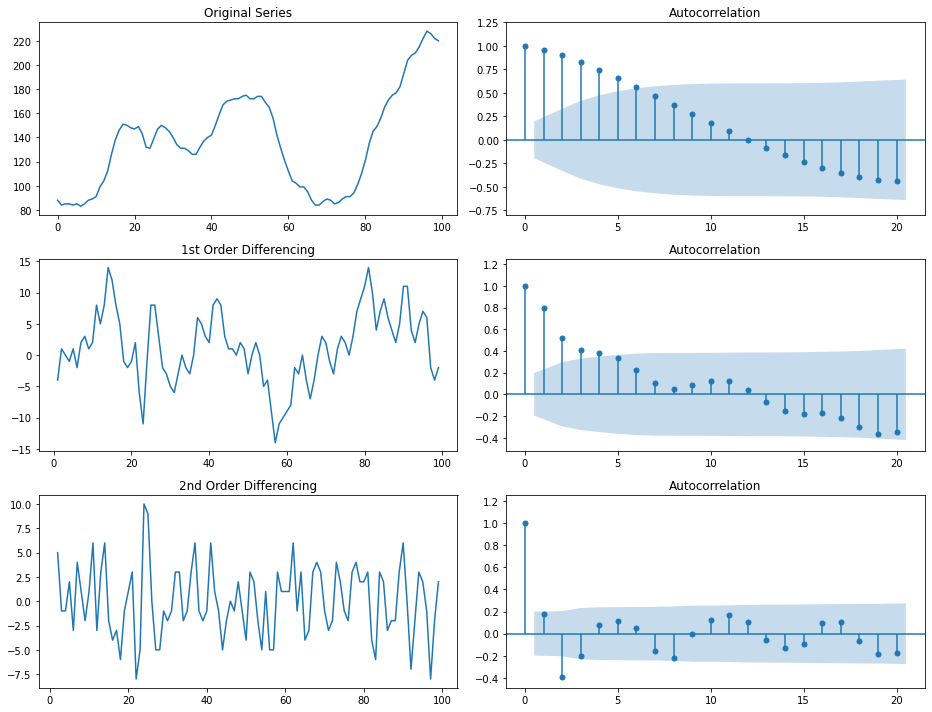

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(13,10))
axes[0, 0].plot(y); axes[0, 0].set_title('Original Series')
plot_acf(y, auto_ylims=True,ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y.diff().dropna(), auto_ylims=True,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y.diff().diff().dropna(), auto_ylims=True, ax=axes[2, 1])

plt.tight_layout()

We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

In [29]:
y_diff = y.diff().dropna()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

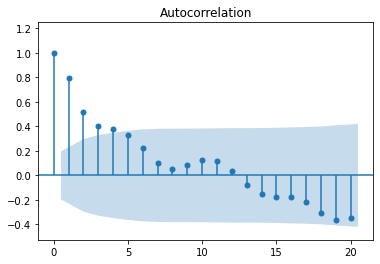

In [31]:
plot_acf(y_diff, auto_ylims=True);

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

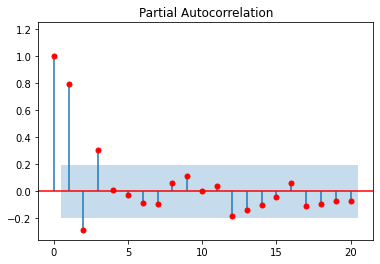

In [32]:
plot_pacf(y_diff, method='ywm', auto_ylims=True, c='r');

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [33]:
from statsmodels.tsa.arima.model import ARIMA

# 1. initialize the model
arima = ARIMA(y, order=(1, 1, 2), trend='t')

# 2. fit the models
arima = arima.fit()

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Date:                Thu, 28 Jul 2022   AIC                            517.580
Time:                        15:01:49   BIC                            530.556
Sample:                             0   HQIC                           522.830
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1199      1.324      0.846      0.398      -1.476       3.716
ar.L1          0.6352      0.144      4.406      0.000       0.353       0.918
ma.L1          0.5285      0.179      2.959      0.003       0.178       0.878
ma.L2         -0.0012      0.168     -0.007      0.994      -0.331       0.328
sigma2         9.7262      1.407      6.913      0.000       6.969      12.484
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.94   Prob(JB):                         0.94
Heteroskedasticity (H):               0.60   Skew:                            -0.08
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
y

0      88.0
1      84.0
2      85.0
3      85.0
4      84.0
      ...  
95    222.0
96    228.0
97    226.0
98    222.0
99    220.0
Name: value, Length: 100, dtype: float32

☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with the `plot_predict()` method

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

In [35]:
from statsmodels.graphics.tsaplots import plot_predict

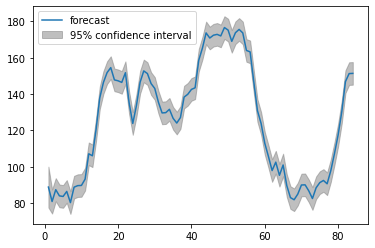

In [64]:
# Actual vs Fitted
plot_predict(arima, start=1, dynamic=False);
# plt.ylim((.9 * y.min(), 1.1 * y.max()));

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

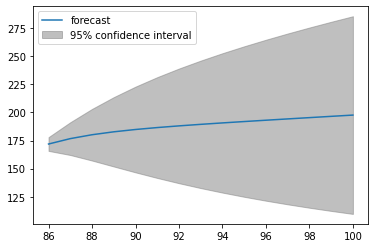

In [37]:
plot_predict(arima, start=86, end=100, dynamic=True)
plt.legend(loc='upper left');

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [38]:
y_train = y[:85]
y_test = y[85:]
arima = ARIMA(y_train, order=(1, 1, 2), trend='t').fit()

In [60]:
y_train

0     88.0
1     84.0
2     85.0
3     85.0
4     84.0
      ... 
70    89.0
71    88.0
72    85.0
73    86.0
74    89.0
Name: value, Length: 75, dtype: float32

👉 We are "now" in step 85 and have never seen the future:
- Use the `get_forecast()` method on your fitted `arima` model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 

This returns a `PredictionResultsWrapper` object from `statsmodels`, store it in a variable `forecast_results`  

It is hard to navigate at first, here are some tips:
- You can find your forecasts in: `forecast_results.predicted_mean`
- Your confidence intervals are given by `forecast_results.conf_int()`

In [41]:
forecast_results = arima.get_forecast(15, alpha=0.05)

In [55]:
forecast_results

In [42]:
forecast = forecast_results.predicted_mean.reset_index(drop=True)
# forecast = arima.forecast(15, alpha=0.05)
conf_int = pd.DataFrame(forecast_results.conf_int().values, columns=['low', 'high'])

In [70]:
forecast

85    163.280512
86    168.330693
87    172.179331
88    175.170761
89    177.550641
90    179.494226
91    181.126549
92    182.536811
93    183.788649
94    184.927464
95    185.985647
96    186.986303
97    187.945920
98    188.876257
99    189.785707
Name: predicted_mean, dtype: float64

In [69]:
pd.DataFrame(forecast_results.conf_int().values, columns=['low', 'high'])

,low,high
0,157.065287,169.495738
1,153.805809,182.855577
2,149.407398,194.951263
3,144.406942,205.934581
4,139.181852,215.919429
5,133.953933,225.034519
6,128.848162,233.404936
7,123.930867,241.142755
8,119.233037,248.344262
9,114.764587,255.090342


👉 Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

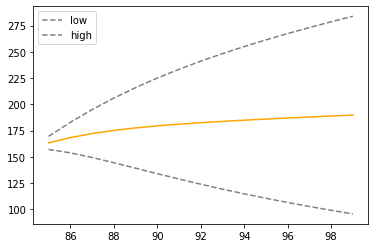

In [66]:
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='grey', ls='--')
plt.plot(conf_int['high'], label='high', c='grey', ls='--')
plt.legend();

In [71]:
conf_int['low']

85    157.065287
86    153.805809
87    149.407398
88    144.406942
89    139.181852
90    133.953933
91    128.848162
92    123.930867
93    119.233037
94    114.764587
95    110.523152
96    106.499515
97    102.680958
98     99.053294
99     95.602091
Name: low, dtype: float64

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

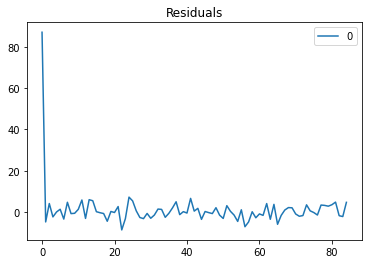

In [46]:
residuals = pd.DataFrame(arima.resid)
residuals.plot(title="Residuals");

In [44]:
forecast.index = y_test.index
conf_int.index = y_test.index

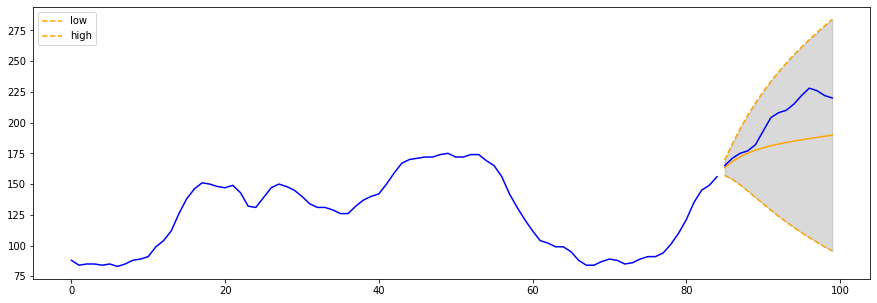

In [45]:
plt.figure(figsize=(15,5))
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='orange', ls='--')
plt.plot(conf_int['high'], label='high', c='orange', ls='--')
plt.plot(y_train, c='blue')
plt.plot(y_test, c='blue')
plt.legend()
plt.fill_between(y_test.index, conf_int['low'], conf_int['high'], color='k', alpha=.15);

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [47]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [48]:
forecast_accuracy(forecast, y_test)

{'mape': 0.09621181873839081,
 'me': -20.66896858575769,
 'mae': 20.66896858575769,
 'mpe': -0.09621181873839081,
 'rmse': 25.065120173209984,
 'acf1': 0.8751997849443472,
 'corr': 0.9570438568320133,
 'minmax': 0.09621181873839091}

## 4 Grid Search

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [78]:
import pmdarima as pm

model = pm.auto_arima(y_train, 
                      start_p=0, max_p=3,
                      start_q=0, max_q=3, 
                      d=None,           # let model determine 'd'
                      test='adf',       # using adftest to find optimal 'd'
                      trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=397.324, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=397.517, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=394.597, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=394.958, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=390.953, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=388.624, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=390.426, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=390.605, Time=0.04 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 0.390 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   75
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -190.312
Date:                Thu, 28 Jul 2022   AIC                   

## (Optional) Cross-validate performance of your model?

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truly evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - Cross-Validation using TimeSeriesSplit + Grid Search**

In [53]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX


range_p = [0, 1, 2]
range_d = [1, 2]
range_q = [0, 1, 2]
grid = itertools.product(range_p, range_d, range_q)
orders = []
r2s = []
aics = []
fold_idxs = []
y = y.astype('float32')
for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]
# Using SARIMAX without seasonality nor exogeneous variables is equivalent to using ARIMA
# SARIMAX's fit method comes with a maxiter keyword, useful to avoid warnings
        model = SARIMAX(y_train, order=order).fit(maxiter=75, disp=False)
#         model = ARIMA(y_train, order=order).fit()
        y_pred = model.forecast(len(y_test))
        r2s.append(r2_score(y_test, y_pred))
        orders.append(order)
        aics.append(model.aic)
        
        
df = pd.DataFrame(list(zip(fold_idxs, orders, aics, r2s)), 
                   columns =['Fold', '(p,d,q)', 'AIC', 'R2'])

/Users/jinru/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jinru/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jinru/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jinru/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zero

In [54]:
df.sort_values('AIC').groupby('(p,d,q)').mean()['AIC'].sort_values()

(p,d,q)
(1, 2, 2)    260.739556
(2, 2, 0)    260.863560
(1, 1, 1)    262.220148
(2, 2, 1)    262.400229
(2, 2, 2)    262.432308
(0, 2, 2)    262.531104
(0, 1, 2)    263.318544
(1, 1, 2)    263.775721
(2, 1, 1)    263.980393
(2, 1, 2)    264.604177
(0, 2, 1)    264.768223
(2, 1, 0)    264.944143
(1, 2, 1)    265.578274
(0, 2, 0)    266.053412
(1, 2, 0)    266.907350
(1, 1, 0)    267.314014
(0, 1, 1)    272.068582
(0, 1, 0)    305.921387
Name: AIC, dtype: float64

☝️ Our initial choice of model (1, 1, 2) is not so bad!
Notice that the dataset (100 datapoints) is in reality way to small to cross-val anything!